In [1]:
num_epoch = 150

In [2]:
# Import the data for each company
import pandas as pd

#Empresa
df = pd.read_csv('IPC.csv')
df

#Define the target
target = "Cierre"

df = df.drop(['Fecha','% var.','Vol.'], axis=1)
df['Cierre'] = df['Cierre'].str.replace(',', '').astype(float)
df['Apertura'] = df['Apertura'].str.replace(',', '').astype(float)
df['Máximo'] = df['Máximo'].str.replace(',', '').astype(float)
df['Mínimo'] = df['Mínimo'].str.replace(',', '').astype(float)
df

,Cierre,Apertura,Máximo,Mínimo
0,54006.92,53656.17,54161.08,53575.13
1,53678.52,53048.38,53789.79,52892.12
2,53043.00,53803.60,54044.65,52923.45
3,53744.78,54346.14,54447.32,53512.77
4,54368.00,54337.22,54594.69,54070.81
...,...,...,...,...
1145,44470.91,44160.55,44515.99,44078.41
1146,44157.81,44522.36,44588.27,44018.06
1147,44495.30,44489.97,44571.74,44287.13
1148,44624.85,44355.21,44742.98,44177.91


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epoch):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 16.472503497177048
Test accuracy: 0.06070722608136953

Epoch 0
---------
Train loss: 0.82101728792594
Train accuracy: 1.2180010005953799
Test loss: 13.11318751950013
Test accuracy: 0.07625910869397899
Epoch 1
---------
Train loss: 0.3737648257609609
Train accuracy: 2.6754784386578425
Test loss: 9.149953621587471
Test accuracy: 0.10929017024869772
Epoch 2
---------
Train loss: 0.13249106066959668
Train accuracy: 7.547673331157362
Test loss: 6.900971627441946
Test accuracy: 0.1449071289516325
Epoch 3
---------
Train loss: 0.08092888669609422
Train accuracy: 12.356512058592992
Test loss: 5.991785368634744
Test accuracy: 0.16689516092235102
Epoch 4
---------
Train loss: 0.05868245815733938
Train accuracy: 17.040838562606712
Test loss: 5.3550724122916025
Test accuracy: 0.18673883457314172
Epoch 5
---------
Train loss: 0.04357721675246135
Train accuracy: 22.94771855000727
Test loss: 4.866305217951906
Test accuracy: 0.20549470998274158
Epoch 6
---------
Trai

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelIPC" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

        Cierre  Model forecast
0     54006.92    53982.183594
1     53678.52    53669.476562
2     53043.00    53048.964844
3     53744.78    53761.101562
4     54368.00    54382.570312
...        ...             ...
1145  44470.91    44508.183594
1146  44157.81    44225.093750
1147  44495.30    44505.472656
1148  44624.85    44631.699219
1149  44437.23    44471.621094

[1151 rows x 2 columns]


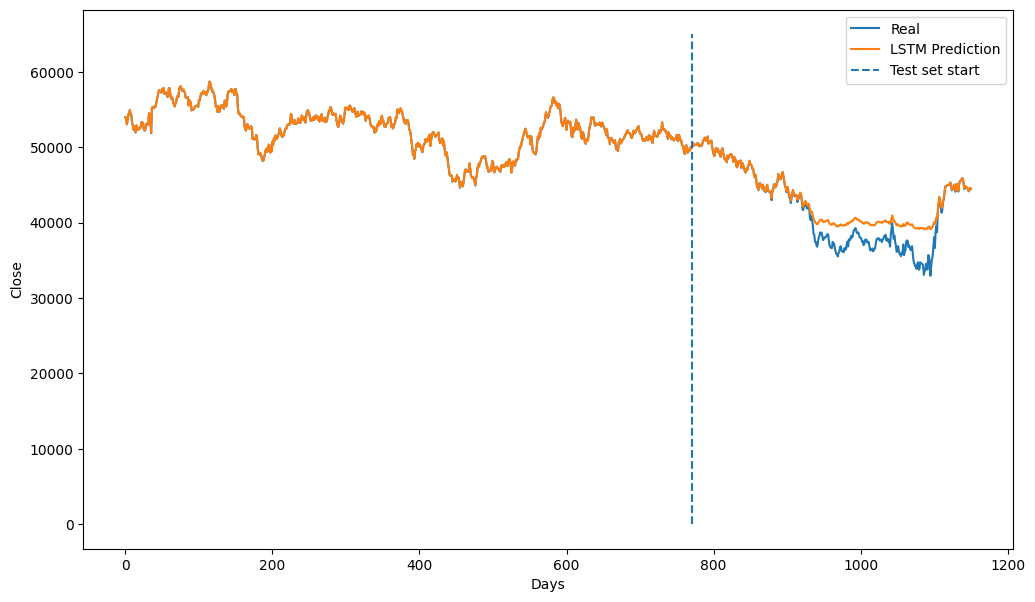

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 65000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

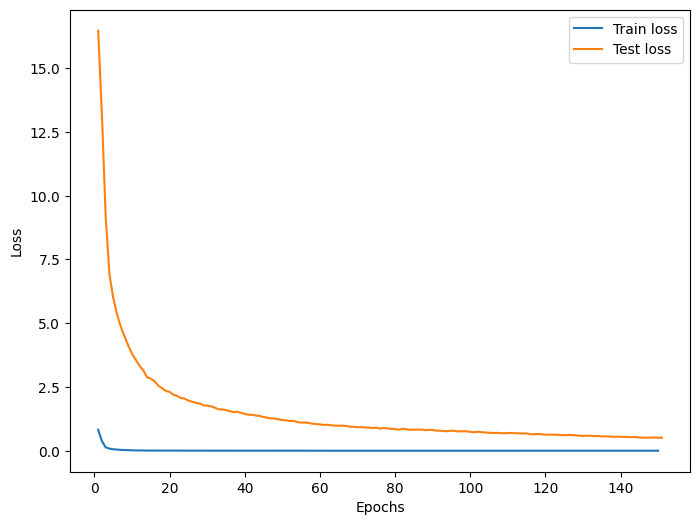

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epoch + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epoch + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [ ]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 16.284944533360633
Test accuracy: 0.06140641079930006
Execution time 16.822166681289673
Epoch 0
---------
Train loss: 0.1185314521984194
Train accuracy: 8.4365722160292
Test loss: 4.6516274871068495
Test accuracy: 0.21497851693281517
Execution time 76.83921122550964
Epoch 1
---------
Train loss: 0.00865951563614442
Train accuracy: 115.47856648811228
Test loss: 3.7886574143851983
Test accuracy: 0.26394573703299606
Execution time 76.4384093284607
Epoch 2
---------
Train loss: 0.005864881298525318
Train accuracy: 170.50352747952297
Test loss: 3.461733996159684
Test accuracy: 0.2888725627740623
Execution time 75.99109649658203
Epoch 3
---------
Train loss: 0.004706835647223503
Train accuracy: 212.45244782343127
Test loss: 3.274651967503277
Test accuracy: 0.3053759542651013
Execution time 75.88766717910767
Epoch 4
---------
Train loss: 0.004095417272941931
Train accuracy: 244.1694011661854
Test loss: 3.185344469184556
Test accuracy: 0.3139377791885161
Exec

In [ ]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelIPC" )

In [ ]:
#Predict using the qmodel
from utils import QShallowRegressionLSTM

#Define the hyperparameters
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 65000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epoch + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epoch + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1, len(df) + 2), df_out["Model forecast"], label = "LSTM")
plt.plot(range(1, len(df) + 2), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 65000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()